In [63]:
import pandas as pd
import numpy as np
import os
from pyimzml.ImzMLParser import ImzMLParser
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from numpy import linspace, dot
import scipy.signal as signal
from numpy.linalg import svd
from matplotlib.pyplot import plot
from sklearn.decomposition import PCA
import pickle
import glob

In [2]:
control = pd.read_csv(r"C:\Users\John\Documents\School\19 Summer\532 ML\CS 532 Project\Data\csvData\aggregates\Control_Day03_01_30x30_aggregated.csv")
injured = pd.read_csv(r"C:\Users\John\Documents\School\19 Summer\532 ML\CS 532 Project\Data\csvData\aggregates\Injured_Day03_01_32x31_aggregated.csv")

In [113]:
os.chdir(r"C:\Users\John\Documents\School\19 Summer\532 ML\CS 532 Project\Data\csvData\aggregates")
files = [(file, get_size_from_filename(file)) for file in glob.glob("*.csv")]

In [114]:
import re
def get_size_from_filename(fname):
    size_search = re.search(r'_(\d\d)x(\d\d)_', fname, re.IGNORECASE)
    return int(size_search.group(1)), int(size_search.group(2))

In [115]:
files

[('Control_Day03_01_30x30_aggregated.csv', (30, 30)),
 ('Control_Day03_02_35x34_aggregated.csv', (35, 34)),
 ('Control_Day03_03_29x27_aggregated.csv', (29, 27)),
 ('Injured_Day03_01_32x31_aggregated.csv', (32, 31)),
 ('Injured_Day03_02_37x33_aggregated.csv', (37, 33)),
 ('Injured_Day03_03_37x34_aggregated.csv', (37, 34))]

In [ ]:
#A, B = kmeans_labels[:900],kmeans_labels[900:]
len(kmeans_labels)

In [ ]:
A = kmeans_labels.reshape(30,30)
plt.imshow(A)

In [ ]:
# r, g, and b are 512x512 float arrays with values >= 0 and < 1.
from PIL import Image
import numpy as np
rgbArray = np.zeros((512,512,3), 'uint8')
rgbArray[..., 0] = r*256
rgbArray[..., 1] = g*256
rgbArray[..., 2] = b*256
img = Image.fromarray(rgbArray)
img.save('myimg.jpeg')

In [5]:
def find_rank(S):
    aggregate_sum = sum(S)
    cum_sum = 0
    for i, v in enumerate(S):
        cum_sum = cum_sum + v
        cum_sum_percent = cum_sum / aggregate_sum
        if cum_sum_percent > .99:
            return i

In [6]:
def pca_with_sklearn():
    df_control_feature_set = pd.read_csv('csvData/aggregated_feature_table_control.csv')
    df_injured_feature_set = pd.read_csv('csvData/aggregated_feature_table_injured.csv')
    num_control_pixels = len(df_control_feature_set)
    num_injured_pixels = len(df_injured_feature_set)
    vec_control_label = np.ones(num_control_pixels)
    vec_injured_label = -1 * np.ones(num_injured_pixels)
    vec_combined_labels = np.concatenate((vec_control_label, vec_injured_label), axis=0)
    df_combined_feature_set = pd.concat([df_control_feature_set, df_injured_feature_set])
    del df_combined_feature_set[df_combined_feature_set.columns[-1]]
    del df_combined_feature_set['Unnamed: 0']

    df_combined_feature_set_standardized = (df_combined_feature_set - df_combined_feature_set.mean()) / df_combined_feature_set.std()
    df_combined_feature_set_standardized = df_combined_feature_set_standardized.fillna(0)

    reduced_data = PCA(n_components=2).fit_transform(df_combined_feature_set_standardized.values)
    kmeans = KMeans(init='k-means++', n_clusters=3, n_init=10)
    kmeans.fit(reduced_data)
    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = 0.1  # point in the mesh [x_min, x_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
    # Plot the centroids as a white X
    centroids = kmeans.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)
    plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
              'Centroids are marked with white cross')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()

In [126]:

def pca(csv_path):
    control = pd.read_csv(csv_path)
    df_control_feature_set =control
    df_injured_feature_set = injured
    num_control_pixels = len(df_control_feature_set)
    num_injured_pixels = len(df_injured_feature_set)
    vec_control_label = np.ones(num_control_pixels)
    vec_injured_label = -1*np.ones(num_injured_pixels)
    vec_combined_labels = vec_control_label #if idx==0 else vec_injured_label #np.concatenate((vec_control_label, vec_injured_label), axis=0)
    df_combined_feature_set = df_control_feature_set# if idx==0 else df_injured_feature_set #pd.concat([df_control_feature_set, df_injured_feature_set])
    del df_combined_feature_set[df_combined_feature_set.columns[-1]]
    del df_combined_feature_set['Unnamed: 0']
    # df_combined_feature_set.to_excel('combined_feature_set.xlsx')
    df_combined_feature_set_standardized = (df_combined_feature_set - df_combined_feature_set.mean()) / df_combined_feature_set.std()
    df_combined_feature_set_standardized = df_combined_feature_set_standardized.fillna(0)

    [U, S, V] = svd(df_combined_feature_set_standardized.values)
    S_DIAG = np.diag(S)

    # THIS IS THE DIM REDUCTION USING FIRST TWO COLS OF V
    #dim_red_data = dot(df_combined_feature_set_standardized.values, V[:2, :].transpose())

    dim_red_data = dot(S_DIAG[:2, :2], U[:, :2].transpose()).transpose()

    kmeans = KMeans(n_clusters=2)
    kmeans.fit(dim_red_data)
    y_kmeans = kmeans.predict(dim_red_data)

    df_clusters = pd.DataFrame(dim_red_data)
    df_clusters['clusters'] = y_kmeans

    x = df_clusters[0]
    y = df_clusters[1]
    plt.scatter(x, y, c=y_kmeans, s=50, cmap='viridis')
    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
    plt.title('Clusters Wattage vs Duration')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()
    return y_kmeans

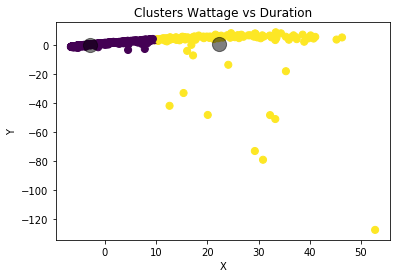

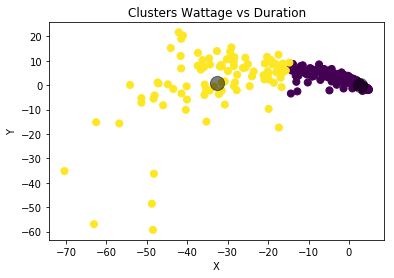

In [129]:
i = 1
labels_control = pca(files[i][0])
labels_injured = pca(files[i+3][0])

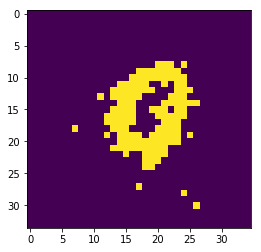

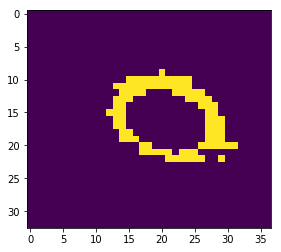

In [130]:
A = labels_control.reshape(*reversed(files[i][1]))
B = labels_injured.reshape(*reversed(files[i+3][1]))
plt.imshow(A)
plt.show()
plt.imshow(B)
plt.show()

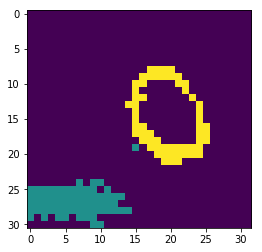

In [60]:
B = labels_injured.reshape(31,32)
plt.imshow(B)

In [61]:
(len(labels_injured)/32)

31.0

In [62]:
math.sqrt(len(labels_control))

30.0